In [1]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.
print(data)

Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [12]:
print(data.y)

tensor([3, 4, 4,  ..., 3, 3, 3])


In [3]:
import torch
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=32)
print(model)

GCN(
  (conv1): GCNConv(1433, 32)
  (conv2): GCNConv(32, 7)
)


In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

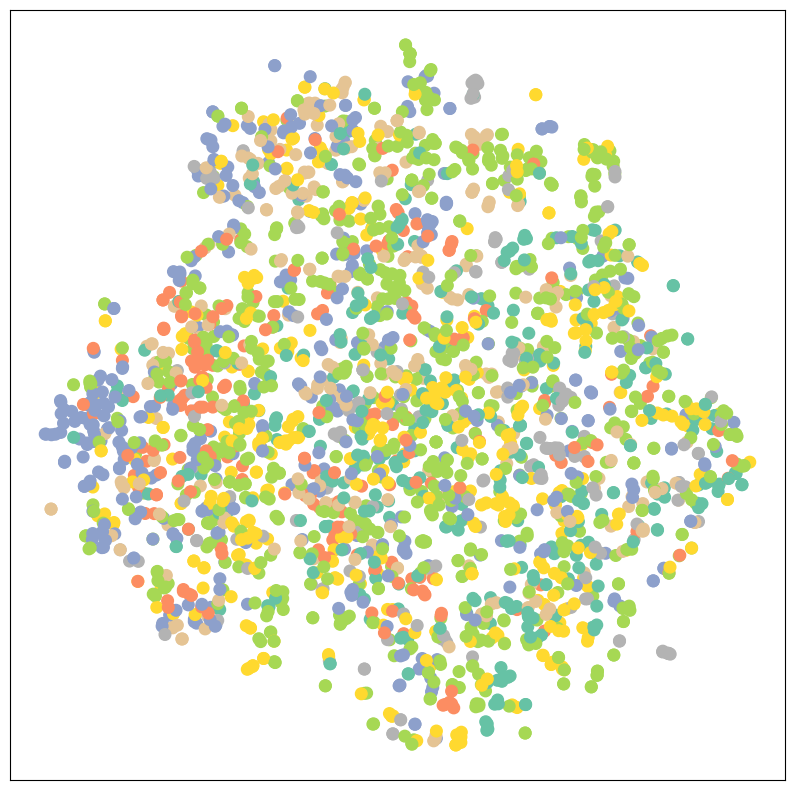

In [5]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

In [6]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()
      out = model(data.x, data.edge_index)
      loss = criterion(out[data.train_mask], data.y[data.train_mask])
      loss.backward()
      optimizer.step()
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)
      test_correct = pred[data.test_mask] == data.y[data.test_mask]
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
      return test_acc


for epoch in range(1, 101):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 1.9455
Epoch: 002, Loss: 1.9400
Epoch: 003, Loss: 1.9309
Epoch: 004, Loss: 1.9180
Epoch: 005, Loss: 1.9058
Epoch: 006, Loss: 1.8934
Epoch: 007, Loss: 1.8779
Epoch: 008, Loss: 1.8592
Epoch: 009, Loss: 1.8494
Epoch: 010, Loss: 1.8245
Epoch: 011, Loss: 1.8075
Epoch: 012, Loss: 1.7893
Epoch: 013, Loss: 1.7692
Epoch: 014, Loss: 1.7412
Epoch: 015, Loss: 1.7192
Epoch: 016, Loss: 1.6908
Epoch: 017, Loss: 1.6828
Epoch: 018, Loss: 1.6326
Epoch: 019, Loss: 1.6089
Epoch: 020, Loss: 1.5959
Epoch: 021, Loss: 1.5634
Epoch: 022, Loss: 1.5426
Epoch: 023, Loss: 1.4932
Epoch: 024, Loss: 1.4759
Epoch: 025, Loss: 1.4473
Epoch: 026, Loss: 1.4263
Epoch: 027, Loss: 1.3863
Epoch: 028, Loss: 1.3437
Epoch: 029, Loss: 1.3084
Epoch: 030, Loss: 1.2828
Epoch: 031, Loss: 1.2385
Epoch: 032, Loss: 1.2029
Epoch: 033, Loss: 1.1789
Epoch: 034, Loss: 1.1715
Epoch: 035, Loss: 1.1197
Epoch: 036, Loss: 1.0807
Epoch: 037, Loss: 1.0921
Epoch: 038, Loss: 1.0493
Epoch: 039, Loss: 1.0141
Epoch: 040, Loss: 0.9605


In [7]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8110


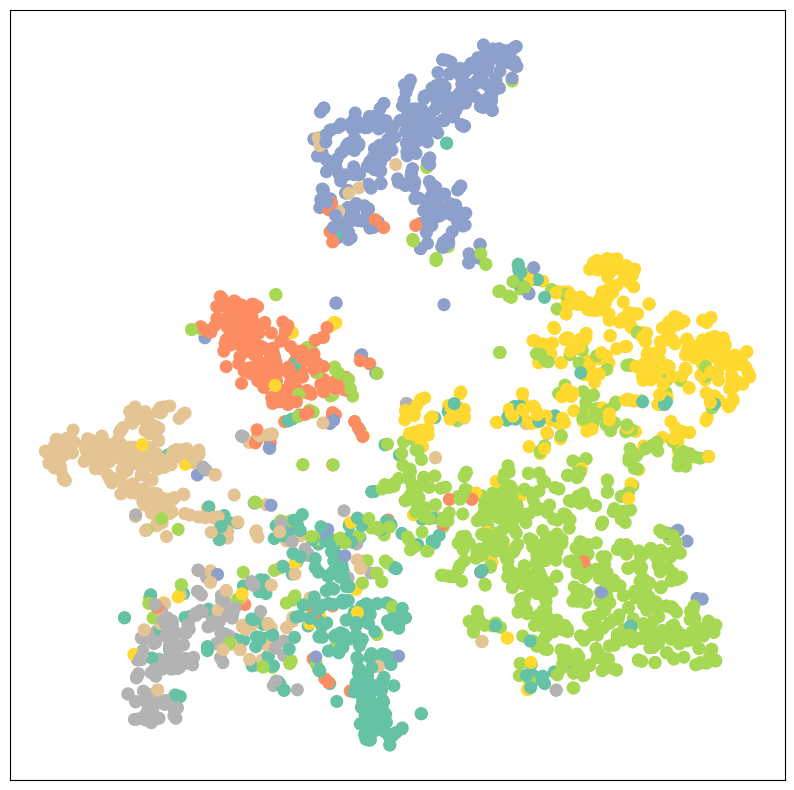

In [13]:
model.eval()
out = model(data.x, data.edge_index)
visualize(out, color=data.y)

In [13]:
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(dataset.num_features, hidden_channels,heads)
        self.conv2 = GATConv(heads*hidden_channels, dataset.num_classes,heads)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GAT(hidden_channels=8, heads=8)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()
      out = model(data.x, data.edge_index)
      loss = criterion(out[data.train_mask], data.y[data.train_mask])
      loss.backward()
      optimizer.step()
      return loss

def test(mask):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)
      correct = pred[mask] == data.y[mask]
      acc = int(correct.sum()) / int(mask.sum())
      return acc

val_acc_all = []
test_acc_all = []

for epoch in range(1, 101):
    loss = train()
    val_acc = test(data.val_mask)
    test_acc = test(data.test_mask)
    val_acc_all.append(val_acc)
    test_acc_all.append(test_acc)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')


GAT(
  (conv1): GATConv(1433, 8, heads=8)
  (conv2): GATConv(64, 7, heads=8)
)
Epoch: 001, Loss: 4.0245, Val: 0.3520, Test: 0.3770
Epoch: 002, Loss: 3.9926, Val: 0.4760, Test: 0.5240
Epoch: 003, Loss: 3.9555, Val: 0.5000, Test: 0.5560
Epoch: 004, Loss: 3.9104, Val: 0.5440, Test: 0.5740
Epoch: 005, Loss: 3.8645, Val: 0.5500, Test: 0.5870
Epoch: 006, Loss: 3.8111, Val: 0.5560, Test: 0.5800
Epoch: 007, Loss: 3.7478, Val: 0.5460, Test: 0.5730
Epoch: 008, Loss: 3.6821, Val: 0.5320, Test: 0.5650
Epoch: 009, Loss: 3.6151, Val: 0.5280, Test: 0.5610
Epoch: 010, Loss: 3.5253, Val: 0.5220, Test: 0.5570
Epoch: 011, Loss: 3.4305, Val: 0.5080, Test: 0.5490
Epoch: 012, Loss: 3.3468, Val: 0.5040, Test: 0.5430
Epoch: 013, Loss: 3.2313, Val: 0.4900, Test: 0.5280
Epoch: 014, Loss: 3.1400, Val: 0.4800, Test: 0.5180
Epoch: 015, Loss: 3.0162, Val: 0.4700, Test: 0.5080
Epoch: 016, Loss: 2.9145, Val: 0.4620, Test: 0.4990
Epoch: 017, Loss: 2.7860, Val: 0.4520, Test: 0.4940
Epoch: 018, Loss: 2.6948, Val: 0.4340

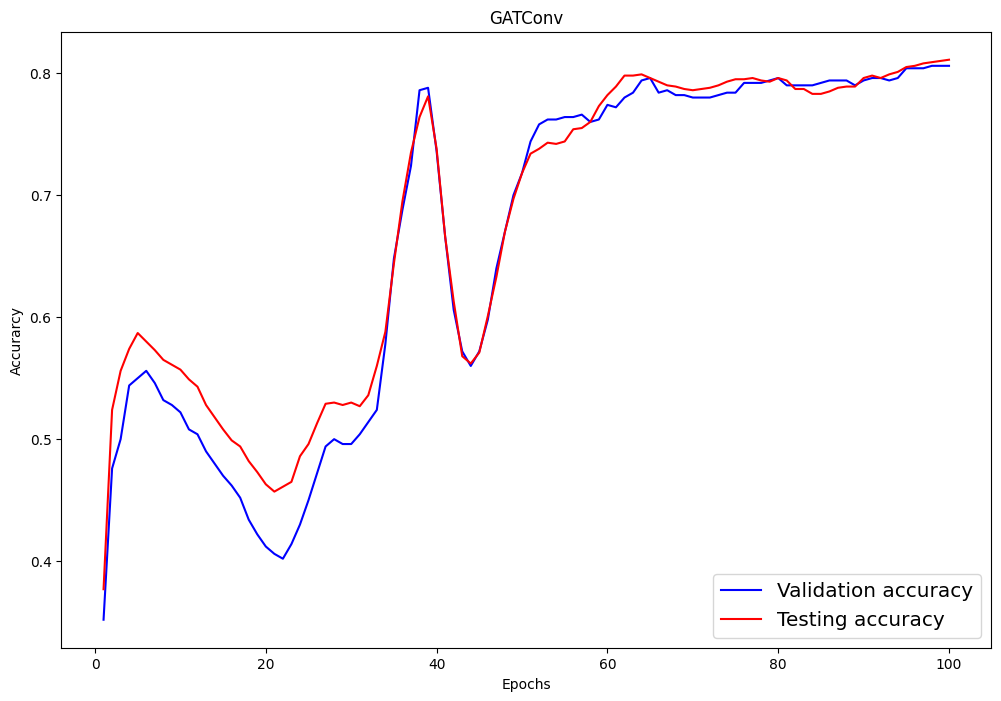

In [14]:
import numpy as np

plt.figure(figsize=(12,8))
plt.plot(np.arange(1, len(val_acc_all) + 1), val_acc_all, label='Validation accuracy', c='blue')
plt.plot(np.arange(1, len(test_acc_all) + 1), test_acc_all, label='Testing accuracy', c='red')
plt.xlabel('Epochs')
plt.ylabel('Accurarcy')
plt.title('GATConv')
plt.legend(loc='lower right', fontsize='x-large')
plt.savefig('gat_loss.png')
plt.show()

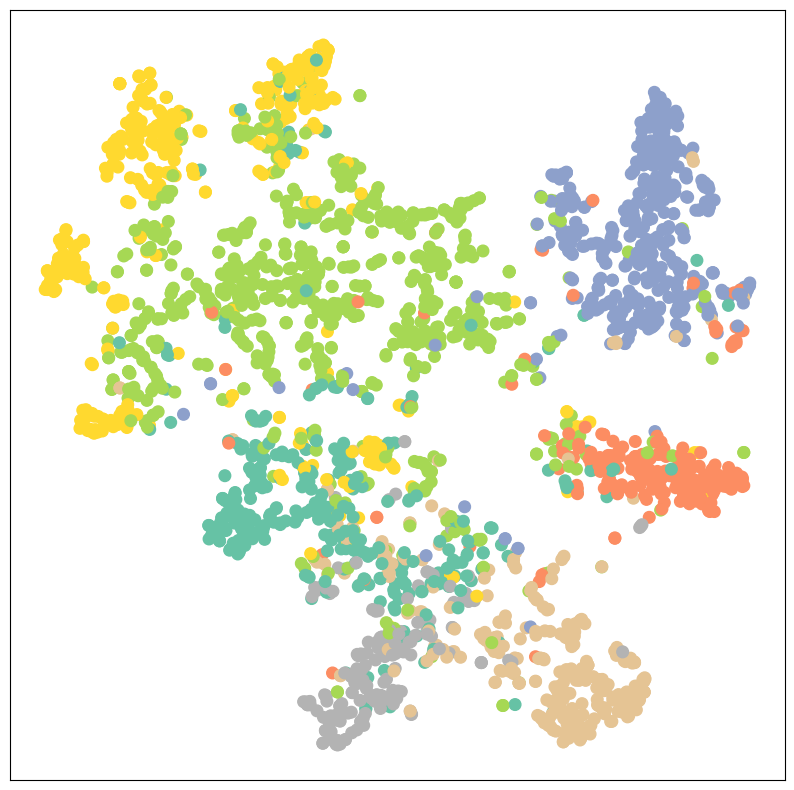

In [15]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)